#Data Cleaning

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Change Headers to Natural language - Each word in Header staring with Upper Case, Words seperate by underscore
# Change CustomerId, InvoiceNo type to object
# Replace Blank Spaces in Customer_Id with nan
# Drop Duplicates
# Treat Date of Purchase
# Remove -ve
# TRANSP

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [8]:
import os
EcomData = pd.read_excel("/content/E-com_Data.xlsx")

In [9]:
print(EcomData.columns)

Index(['CustomerID', 'Item Code', 'InvoieNo', 'Date of purchase', 'Quantity',
       'Time', 'price per Unit', 'Price', 'Shipping Location',
       'Cancelled_status', 'Reason of return', 'Sold as set'],
      dtype='object')


In [10]:
EcomData.rename(columns = {'CustomerID':'Customer_Id', 'Item Code':'Item_Code',
                              'InvoieNo':'Invoice_No', 'Date of purchase':'Date_Of_Purchase',
                              'price per Unit':'Price_Per_Unit','Shipping Location':'Shipping_Location',
                              'Cancelled_status':'Cancelled_Status','Reason of return':'Reason_Of_Return',
                              'Sold as set':'Sold_As_Set'}, inplace = True)
print(EcomData.columns)

Index(['Customer_Id', 'Item_Code', 'Invoice_No', 'Date_Of_Purchase',
       'Quantity', 'Time', 'Price_Per_Unit', 'Price', 'Shipping_Location',
       'Cancelled_Status', 'Reason_Of_Return', 'Sold_As_Set'],
      dtype='object')


In [11]:
EcomData = EcomData.astype({'Customer_Id':'str', 'Invoice_No':'str'})
EcomData.replace(r'\s+',np.nan,regex=True).replace('',np.nan)
x = EcomData[EcomData.Customer_Id=='nan']
x.shape

(133790, 12)

In [12]:
#Remove Duplicate Rows
EcomData = EcomData.drop_duplicates(subset=['Customer_Id', 'Item_Code', 'Invoice_No', 'Date_Of_Purchase',
       'Quantity', 'Time', 'Price_Per_Unit', 'Price', 'Shipping_Location',
       'Cancelled_Status', 'Reason_Of_Return', 'Sold_As_Set'])
EcomData.shape
# 9 Duplicate rows removed

(537970, 12)

In [13]:
# Dropping TRANSP
EcomData = EcomData[EcomData.Item_Code!='TRANSP']
EcomData.shape
# 144 rows removed

(537826, 12)

In [14]:
# Dropping Blank Customer ID
EcomData = EcomData[EcomData.Customer_Id!='nan']
EcomData.shape
# 133779 rows removed

(404047, 12)

In [15]:
# Remove Negative Quantity
EcomData_NR = EcomData[EcomData.Quantity>0]
EcomData_NR.shape
# 8182 Rows Removed
# Total Rows Removed = 142114 (26.4%)

(395865, 12)

In [16]:
# Preparing Data for RFM
RFM1= EcomData_NR.iloc[:,0:9]
RFM1=RFM1.drop(['Item_Code','Quantity','Time','Price_Per_Unit','Shipping_Location'], axis = 1)

In [17]:
print(EcomData.shape)
print(RFM1.shape)
RFM1

(404047, 12)
(395865, 4)


,Customer_Id,Invoice_No,Date_Of_Purchase,Price
0,4355.0,398177,2017-10-29,1926.0
1,4352.0,394422,2017-10-05,1740.0
2,4352.0,394422,2017-10-12,1866.0
3,4352.0,388633,2017-08-22,1869.0
4,4352.0,394422,2017-10-10,1888.0
...,...,...,...,...
537945,37.0,402292,2017-11-28,384.0
537946,37.0,402292,2017-11-27,398.0
537947,21.0,363890,2016-12-21,2464.0
537948,21.0,363890,2016-12-21,4068.0


In [18]:
RFM_Data = RFM1

In [19]:
import datetime as dt
#Reference Date
Now = max(RFM_Data['Date_Of_Purchase'])

In [20]:
df_recency = RFM_Data.groupby(['Customer_Id'],as_index=False)['Date_Of_Purchase'].max()
df_recency.columns = ['Customer_Id','Last_Purchase_Date']
df_recency['Recency'] = (Now-df_recency['Last_Purchase_Date']).dt.days
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
FM_Table = RFM_Data.groupby('Customer_Id').agg({'Invoice_No'   : lambda x:len(x),
                                         'Price'  : lambda x:x.sum()})
FM_Table.rename(columns = {'Invoice_No' :'Frequency',
                           'Price':'Monetary_Value'},inplace= True)
RFM_Table = df_recency.merge(FM_Table,left_on='Customer_Id',right_on='Customer_Id')
RFM_Table.head()

,Customer_Id,Recency,Frequency,Monetary_Value
0,10.0,24,58,331601.0
1,100.0,187,36,85862.0
2,1000.0,3,37,263771.0
3,1001.0,182,8,10575.0
4,1002.0,63,6,111008.0


In [21]:
quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
RFM_Table_seg = RFM_Table.copy()
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
RFM_Table_seg['R_quartile'] = RFM_Table_seg['Recency'].apply(RScore, args=('Recency',quantiles))
RFM_Table_seg['F_quartile'] = RFM_Table_seg['Frequency'].apply(FMScore, args=('Frequency',quantiles))
RFM_Table_seg['M_quartile'] = RFM_Table_seg['Monetary_Value'].apply(FMScore, args=('Monetary_Value',quantiles))
RFM_Table_seg['RFM_Segment'] = RFM_Table_seg.R_quartile.map(str)+RFM_Table_seg.F_quartile.map(str)+RFM_Table_seg.M_quartile.map(str)
RFM_Table_seg['RFM_Score'] = RFM_Table_seg[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
RFM_Table_seg.head()

<ipython-input-21-f7bf73fb3acf>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = RFM_Table.quantile(q=[0.25,0.50,0.75])


,Customer_Id,Recency,Frequency,Monetary_Value,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,10.0,24,58,331601.0,2,2,1,221,5
1,100.0,187,36,85862.0,4,3,3,433,10
2,1000.0,3,37,263771.0,1,3,1,131,5
3,1001.0,182,8,10575.0,4,4,4,444,12
4,1002.0,63,6,111008.0,3,4,2,342,9


In [22]:
print("Best Customers: ",len(RFM_Table_seg[RFM_Table_seg['RFM_Segment']=='111']))
print('Regular Customers: ',len(RFM_Table_seg[RFM_Table_seg['F_quartile']==1]))
print("Big Spenders: ",len(RFM_Table_seg[RFM_Table_seg['M_quartile']==1]))
print('Almost Lost Customers: ', len(RFM_Table_seg[RFM_Table_seg['RFM_Segment']=='134']))
print('Lost Customers: ',len(RFM_Table_seg[RFM_Table_seg['RFM_Segment']=='344']))
print('Lost Worst Customers: ',len(RFM_Table_seg[RFM_Table_seg['RFM_Segment']=='444']))

Best Customers:  456
Regular Customers:  1072
Big Spenders:  1081
Almost Lost Customers:  24
Lost Customers:  181
Lost Worst Customers:  407


# Pre-processing for K- Means Clustering

In [23]:
# K-means gives the best result under the following conditions:

# Data’s distribution is not skewed.
# Data is standardised.

In [24]:
RFM_Table.head()

,Customer_Id,Recency,Frequency,Monetary_Value
0,10.0,24,58,331601.0
1,100.0,187,36,85862.0
2,1000.0,3,37,263771.0
3,1001.0,182,8,10575.0
4,1002.0,63,6,111008.0


In [25]:
RFM_Table = RFM_Table.astype({'Customer_Id':'float'})

In [26]:
RFM_Table.head()
RFM_Table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4324 entries, 0 to 4323
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Customer_Id     4324 non-null   float64
 1   Recency         4324 non-null   int64  
 2   Frequency       4324 non-null   int64  
 3   Monetary_Value  4324 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 168.9 KB


### Check Skewness

In [27]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}".format(column, skew))
    return

<ipython-input-27-2b1f210b83e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column])


Recency's: Skew: 1.2444498926187022


<ipython-input-27-2b1f210b83e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column])


Frequency's: Skew: 18.075431082391653


<ipython-input-27-2b1f210b83e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column])


Monetary_Value's: Skew: 22.380087010683194


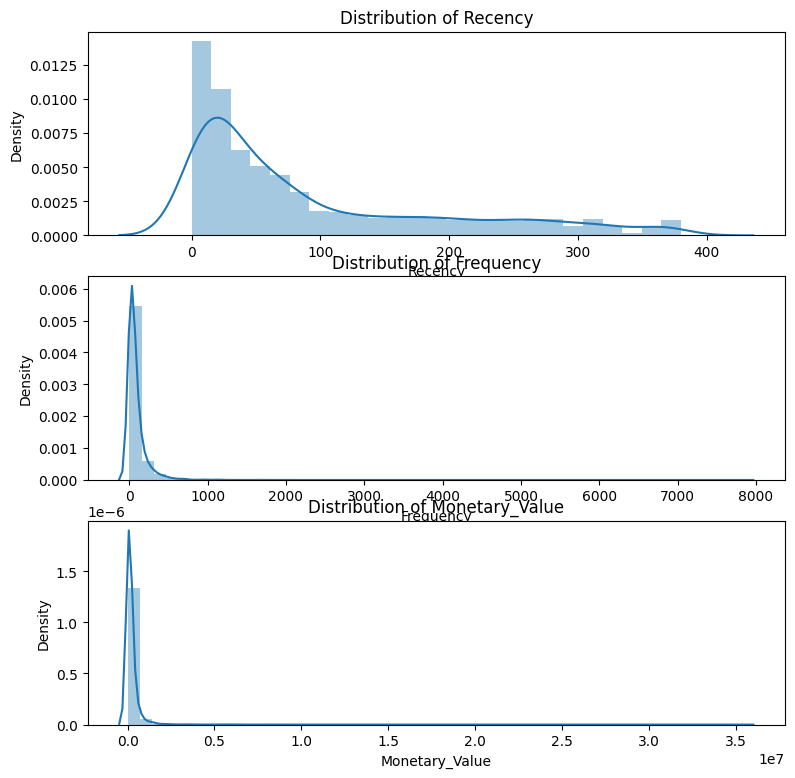

In [28]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(RFM_Table,'Recency')

plt.subplot(3, 1, 2)
check_skew(RFM_Table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(RFM_Table,'Monetary_Value')


In [29]:
# The data is highly skewed,therefore we will perform log transformations to reduce the skewness of each variable.
# We add a small constant as log transformation demands all the values to be positive.

In [30]:
df_rfm_log = RFM_Table.copy()

<ipython-input-27-2b1f210b83e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column])


Recency's: Skew: -0.434050456343557


<ipython-input-27-2b1f210b83e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column])


Frequency's: Skew: -0.00982992994682339


<ipython-input-27-2b1f210b83e7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_skew[column])


Monetary_Value's: Skew: 0.25603333597876865


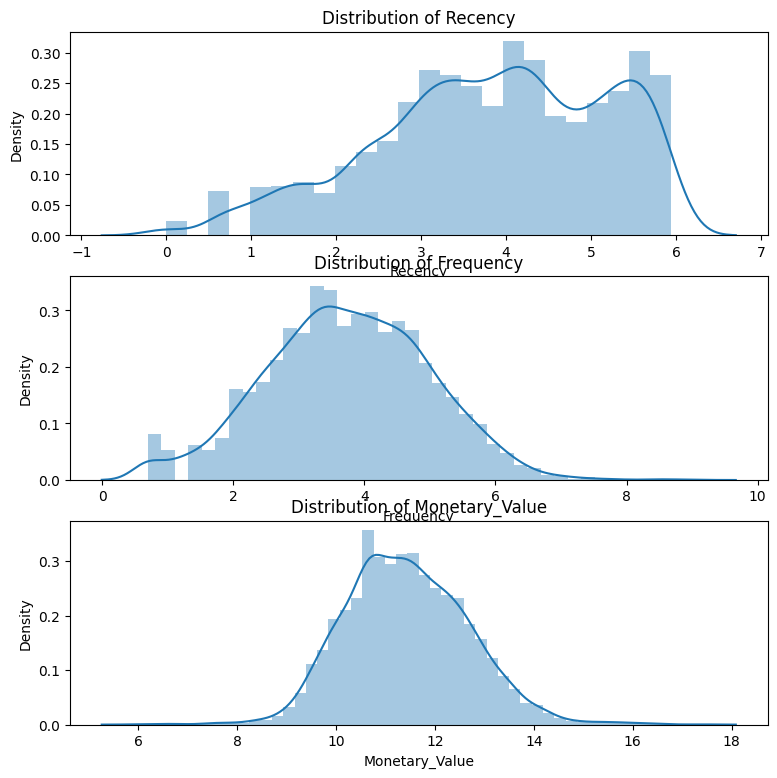

In [31]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary_Value')


In [32]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 5.9 MB/s eta 0:00:00


In [33]:
from feature_engine.outliers import Winsorizer

In [34]:
winsorizer = Winsorizer(capping_method='gaussian',
                          tail='both', # cap left, right or both tails
                          fold=2,
                           variables=['Recency','Frequency','Monetary_Value'])
winsorizer.fit(df_rfm_log)

Winsorizer(fold=2, tail='both',
           variables=['Recency', 'Frequency', 'Monetary_Value'])

In [35]:
df_rfm_log = winsorizer.transform(df_rfm_log)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(df_rfm_log)

RFM_Table_scaled = scaler.transform(df_rfm_log)

In [37]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)

In [38]:
RFM_Table_scaled.head()

,Customer_Id,Recency,Frequency,Monetary_Value
0,-5.067664,-0.476419,0.282175,1.102316
1,-2.815381,1.056713,-0.106885,-0.049848
2,-0.485480,-1.868984,-0.084650,0.907174
3,-0.484466,1.036230,-1.285602,-1.835560
4,-0.483452,0.237885,-1.495144,0.169177


In [39]:
RFM_Table_scaled.to_excel("RFM_Table_scaled.xlsx")

# Finding the optimal number of clusters

In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
model = kmeans.fit(RFM_Table_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

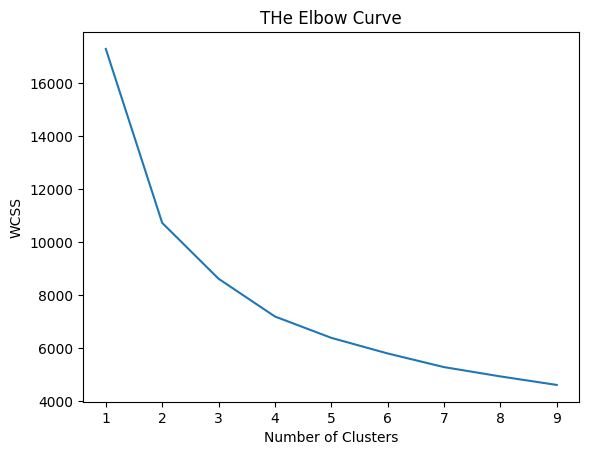

In [42]:
# Creating a function with KMeans to plot "The Elbow Curve"

wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i,init='k-means++' ,max_iter=50,random_state=0)
    kmeans.fit(RFM_Table_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('THe Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel("WCSS") #WCSS stands for total within-cluster sum of sqaure
plt.show()

In [43]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(RFM_Table_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)